# Importing Libraries

In [1]:
import pickle 
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Exploring Pickle file of Subject 2

In [2]:
file_path = "/kaggle/input/wesad-full-dataset/WESAD/S2/S2.pkl"

with open(file_path, "rb") as file:
    s2 = pickle.load(file, encoding="latin1")

print(s2)


{'signal': {'chest': {'ACC': array([[ 0.95539999, -0.222     , -0.55799997],
       [ 0.92579997, -0.2216    , -0.55379999],
       [ 0.90820003, -0.21960002, -0.53920001],
       ...,
       [ 0.87179995, -0.12379998, -0.30419999],
       [ 0.87300003, -0.12339997, -0.30260003],
       [ 0.87020004, -0.12199998, -0.30220002]]), 'ECG': array([[ 0.02142334],
       [ 0.02032471],
       [ 0.01652527],
       ...,
       [-0.00544739],
       [ 0.00013733],
       [ 0.0040741 ]]), 'EMG': array([[-0.00444031],
       [ 0.00434875],
       [ 0.00517273],
       ...,
       [-0.01716614],
       [-0.02897644],
       [-0.02357483]]), 'EDA': array([[5.25054932],
       [5.26733398],
       [5.24330139],
       ...,
       [0.36048889],
       [0.36582947],
       [0.365448  ]]), 'Temp': array([[30.120758],
       [30.129517],
       [30.138214],
       ...,
       [31.459229],
       [31.484283],
       [31.456268]], dtype=float32), 'Resp': array([[-1.14898682],
       [-1.12457275],
       

In [3]:
print(type(s2))

<class 'dict'>


In [4]:
print(s2.keys())

dict_keys(['signal', 'label', 'subject'])


In [5]:
print(s2['signal'].keys())

dict_keys(['chest', 'wrist'])


In [6]:
print(s2['signal']['chest'].keys())

dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])


In [12]:
print(s2['signal']['wrist'].keys())

dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])


## Plotting ECG Signal

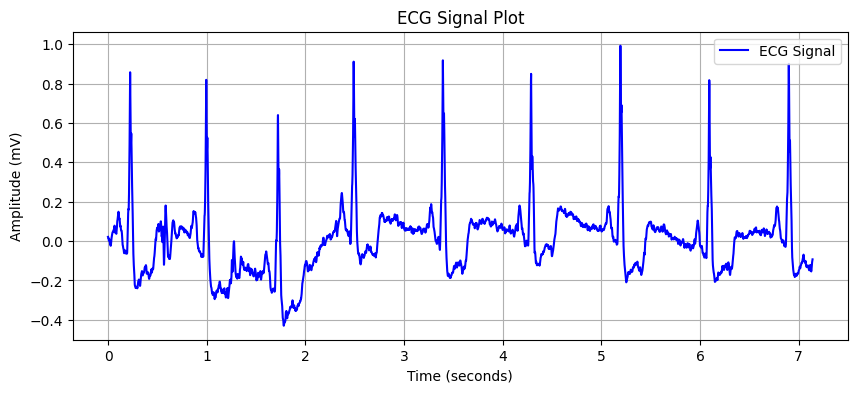

In [22]:
ecg_data = s2['signal']['chest']['ECG'][:5000]


# تحويل المصفوفة إلى شكل 1D (تفريغ القيم من الشكل العمودي)
ecg_signal = ecg_data.flatten()

# إنشاء محور الزمن
ecg_fs = 700  # معدل العينة (Hz)
time = np.arange(len(ecg_signal)) / ecg_fs  # تحويل المحور إلى الثواني

# رسم إشارة ECG
plt.figure(figsize=(10, 4))
plt.plot(time, ecg_signal, label="ECG Signal", color='b')
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude (mV)")
plt.title("ECG Signal Plot")
plt.legend()
plt.grid()
plt.show()

In [8]:
print(type(ecg_data), type(ecg_signal), type(time))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [9]:
print(ecg_data)

[[ 0.02142334]
 [ 0.02032471]
 [ 0.01652527]
 ...
 [-0.1003418 ]
 [-0.09645081]
 [-0.09269714]]


In [10]:
print(ecg_signal)

[ 0.02142334  0.02032471  0.01652527 ... -0.1003418  -0.09645081
 -0.09269714]


In [11]:
print(time)

[   0    1    2 ... 4997 4998 4999]


## Data Framing